In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import tqdm

In [89]:
class Space:
    
    def __init__(self, pitch=1, dims=(800, 800, 800), emission_type="lambertian", 
                 anisotropy=0.9, absorption_length=1000, scatter_length=1000):
        # irradiation field grid
        self.pitch = pitch   # um
        self.dims = dims   # voxels
        self.volume = np.zeros(self.dims)
        
        self.emission_type = emission_type
        
        # simulated photon packets: positions and directions
        self.n = 1000  # photon packets at a time
        self.positions = np.empty((self.n, 3))   # um
        self.directions = np.empty((self.n, 3))
        
        # simulation parameters
        self.mui = 1/absorption_length   # absorption rate: 1/um
        self.mue = 1/scatter_length   # scatter rate: 1/um
        self.mu = self.mui + self.mue  # total rate
        self.absorb_ratio = self.mui/self.mu  # probability of absoprtion at each hop
        self.anisotropy = anisotropy  # For the Henyey-Greenstein formula
        
        self.total_count = 0
        
    def emit(self, which):
        """
        generate new photons in positions 0:m
        """
        m = which.sum()
        self.positions[which, :] = np.random.randn(m, 3)*20 # intial position
        self.positions[which, 2] = -200  # um
        
        if self.emission_type == "parallel":
            self.directions[which, :] = 0.2, 0.2, 0.92**0.5
        elif self.emission_type == "lambertian":
            s = np.random.rand(m)**0.5
            p = np.random.rand(m) * 2 * np.pi
            self.directions[which, :] = np.stack((s*np.cos(p), s*np.sin(p), np.sqrt(1-s*s))).T
        else:
            raise Exception('invalid emission type')
        
    def accumulate(self, start_points, end_points, lengths):
        """
        accumulate irradiation intensity between start_points and end_points
        """
        samples = 40   # points per hop  
        for i in range(samples):
            fractions = np.random.rand(self.n)[:, None]
            dims = np.array(self.dims)
            positions = np.round(dims/2 + 
                (start_points * fractions + end_points * (1 - fractions)) / self.pitch).astype(np.int32)
            keep = np.all(np.logical_and(positions >= 0, positions < dims), axis=1)
            positions = positions[keep, :]
            indices = np.ravel_multi_index((positions[:,0], positions[:,1], positions[:,2]), self.volume.shape)
            self.volume.ravel()[indices] += lengths[keep] / samples
        
    def hop(self):
        """
        execute photon hops between events, updating the irradition field
        """
        # irradiate
        lengths = np.random.exponential(1./self.mu, self.n) 
        new_positions = self.positions + lengths[:, None] * self.directions
        self.accumulate(self.positions, new_positions, lengths)
        
        # absorb
        absorbed = np.random.randn(self.n) < self.absorb_ratio
        self.emit(absorbed)
        self.total_count += absorbed.sum()
        
        # scatter: gcos follows the Henyey-Greenstein distribution of cosines
        scattered = np.logical_not(absorbed)
        m = scattered.sum()
        g = self.anisotropy
        gcos = 0.5 / g * (1 + g*g - ((1 - g*g)/(1 - g + 2*g * np.random.rand(m)))**2)
        gsin = np.sqrt(1-gcos*gcos)
        v = self.directions[scattered] * np.sign(gcos[:,None])
        d = np.random.randn(m, 3)*0.001
        d -= v * (v*d).sum(axis=1, keepdims=True)  # random orthogonal vector
        v += gsin[:,None] / np.sqrt((d**2).sum(axis=1, keepdims=True)) * d  # match length to gsin
        v /= np.sqrt((v**2).sum(axis=1, keepdims=True))  # normalize
        self.directions[scattered, :] = v        
        
    def run(self, hops=1000):
        self.emit(np.ones(self.n, dtype=np.bool))
        for _ in tqdm.tqdm(range(hops)):
            self.hop()
            
            
    def plot(self, figsize=(8, 8)):
        fig, ax = plt.subplots(1,1, figsize=(8, 8))
        ax.imshow(np.sqrt(self.volume.max(axis=1)), cmap='magma')
        ax.axis(False)
        scale_bar = ScaleBar(self.pitch*1e-6)
        ax.add_artist(scale_bar);
        ax.set_title(f"Simulation with {int(round(space.total_count/1e6))} million photons")

100%|██████████| 1000/1000 [00:08<00:00, 112.84it/s]


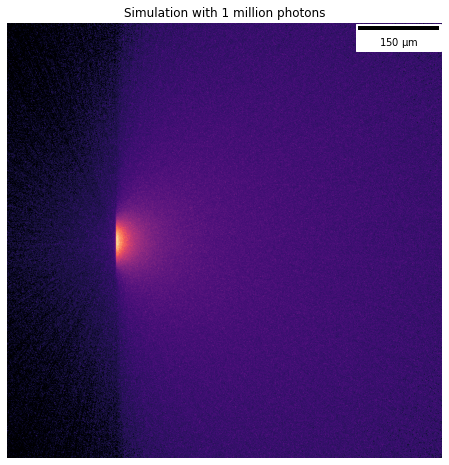

In [90]:
space = Space()
space.run()
space.plot()

100%|██████████| 1000/1000 [00:07<00:00, 136.44it/s]


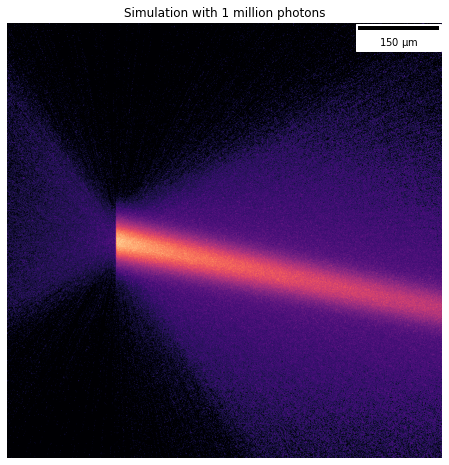

In [91]:
space = Space(emission_type="parallel")
space.run()
space.plot()

100%|██████████| 1000/1000 [00:07<00:00, 127.40it/s]


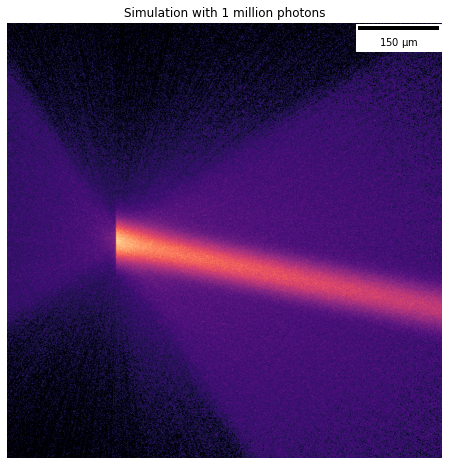

In [94]:
space = Space(emission_type="parallel", anisotropy=0.6)
space.run()
space.plot()